## RegNet Training

In [1]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import regnet_y_1_6gf, RegNet_Y_1_6GF_Weights
from torchvision import transforms
from IPython.display import Audio
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import torch.nn.functional as F
from torchaudio import functional as F_audio
from tqdm import tqdm
import timm
import torchaudio
import torchaudio.transforms as T_audio

import copy
import random
import glob
import os
import time
import sys
import re
import pywt

In [2]:
RANDOM_SEED = 21

# Set seed for experiment reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
## REUSE IN INFERENCE NOTEBOOK

custom_dataset_path = '/kaggle/input/birdclef2023-inference'
if os.path.exists(os.path.join(custom_dataset_path, 'utils.py')):
    sys.path.append(custom_dataset_path)
else:
    sys.path.append('..')
import utils

IS_IN_KAGGLE_ENV = utils.get_is_in_kaggle_env()

DATA_PATH = '/kaggle/input/birdclef-2023' if IS_IN_KAGGLE_ENV else '../data'
JOBLIB_PATH = custom_dataset_path if IS_IN_KAGGLE_ENV else './'

DEVICE = 'cpu' if IS_IN_KAGGLE_ENV else utils.determine_device()

AUDIO_LENGTH_S = 5
SAMPLE_RATE = 32_000

We are running code on Localhost
We are using device: mps


In [4]:
if not IS_IN_KAGGLE_ENV and not os.path.exists(DATA_PATH):
    print("Downloading data ...")
    !kaggle competitions download -c 'birdclef-2023'
    !mkdir ../data
    !unzip -q birdclef-2023.zip -d ../data
    !rm birdclef-2023.zip

DF_METADATA_CSV = pd.read_csv(f"{DATA_PATH}/train_metadata.csv")

AUDIO_DATA_DIR = f"{DATA_PATH}/train_audio/"

In [5]:
# Rows with 1 sample: copy twice, rows with 2 samples: copy once
# This is to ensure that stratified sampling for train/valid/test splits works correctly
def ensure_min_two_samples(DF_METADATA_CSV):
    class_counts = DF_METADATA_CSV["primary_label"].value_counts()

    one_sample_rows = DF_METADATA_CSV[DF_METADATA_CSV["primary_label"].isin(class_counts[class_counts == 1].index)]
    print(f"Number of rows with 1 sample: {len(one_sample_rows)}")
    if len(one_sample_rows) > 0:
        DF_METADATA_CSV = pd.concat([DF_METADATA_CSV, one_sample_rows, one_sample_rows], ignore_index=True)
    
    two_sample_rows = DF_METADATA_CSV[DF_METADATA_CSV["primary_label"].isin(class_counts[class_counts == 2].index)]
    print(f"Number of rows with 2 samples: {len(two_sample_rows)}")
    if len(two_sample_rows) > 0:
        DF_METADATA_CSV = pd.concat([DF_METADATA_CSV, two_sample_rows], ignore_index=True)

    return DF_METADATA_CSV

DF_METADATA_CSV = ensure_min_two_samples(DF_METADATA_CSV)

# Run again to verify
DF_METADATA_CSV = ensure_min_two_samples(DF_METADATA_CSV)

Number of rows with 1 sample: 7
Number of rows with 2 samples: 6
Number of rows with 1 sample: 0
Number of rows with 2 samples: 0


In [6]:
## REUSE IN INFERENCE NOTEBOOK

class BirdMelspecClf(nn.Module):
    def __init__(self, out_features, pretrained):
        super().__init__()
        
        # https://pytorch.org/vision/stable/models.html
        self.regnet = regnet_y_1_6gf(weights=RegNet_Y_1_6GF_Weights.DEFAULT) if pretrained else regnet_y_1_6gf()

        """
        Original: 
        (stem): SimpleStemIN(
            (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            )
        )"""
        self.regnet.stem[0] = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        
        # Replace original classifier: (fc): Linear(in_features=888, out_features=1000, bias=True)
        self.regnet.fc = nn.Linear(self.regnet.fc.in_features, out_features)

        self.softmax = nn.Softmax(dim=1)
 
    def forward(self, x):
        logits = self.regnet(x)
        probas = self.softmax(logits)

        return logits, probas


def get_model(out_features, device, pretrained=False, load_state_dict=True, state_dict_starts_with=f"{AUDIO_LENGTH_S}s_regnetY16GF"):
    model = BirdMelspecClf(out_features=out_features, pretrained=pretrained)
    print(f"Loaded model {model.__class__.__name__} with {sum(p.numel() for p in model.parameters())} parameters, pretained={pretrained}")
    model.to(device)

    if not load_state_dict:
        return model

    model_files = [f for f in os.listdir(JOBLIB_PATH) if f.startswith(state_dict_starts_with) and f.endswith('.pt')]
    if len(model_files) == 0:
        print(f"No model starting with {state_dict_starts_with} found in {JOBLIB_PATH}")
        return model
    
    # Extract timestamp from the filenames and sort based on it
    model_files.sort(key=lambda x: int(re.findall(r'\d+', x)[-1]) if re.findall(r'\d+', x) else -1)

    # The latest model file is the last one in the sorted list
    latest_model_file = model_files[-1]
    model_path = os.path.join(JOBLIB_PATH, latest_model_file)
    model.load_state_dict(torch.load(model_path))
    print(f"Loaded model weights from {model_path}")
    model.to(device)

    return model

In [7]:
UNIQUE_CLASSES = DF_METADATA_CSV.primary_label.unique()
N_CLASSES = len(UNIQUE_CLASSES)
print(f"Number of classes: {N_CLASSES}")

Number of classes: 264


In [8]:
train_classes_paths = glob.glob(f"{DATA_PATH}/train_audio/*")
len(train_classes_paths), train_classes_paths[0]

(264, '../data/train_audio/ruegls1')

In [9]:
print(f"Total samples in dataset: {len(DF_METADATA_CSV)}")

Total samples in dataset: 16961


In [10]:
class_with_fewest_samples = DF_METADATA_CSV.primary_label.value_counts(sort=True).index[-1]
print(f"Class with fewest samples: {class_with_fewest_samples}: {DF_METADATA_CSV.primary_label.value_counts().min()} samples")

Class with fewest samples: crefra2: 3 samples


In [11]:
class WaveletTransformSingle(nn.Module):
  def __init__(
      self, 
      wavelet: pywt.Wavelet,
      cut_to_nearest: int | None = None
  ):
    super(WaveletTransformSingle, self).__init__()
    self.wavelet = wavelet
    self.ctn = cut_to_nearest

  def forward(self, X: torch.Tensor) -> torch.Tensor:
    item = X.cpu().numpy()
    
    wh, wl = pywt.dwt(item[0], self.wavelet)
    out = torch.stack((torch.from_numpy(wh), torch.from_numpy(wl)))
    
    if self.ctn is not None:
      out = out[:,:-1 * (out.shape[-1] % self.ctn)]
    
    return out

In [12]:
## REUSE IN INFERENCE NOTEBOOK

def resample(audio, current_sample_rate, desired_sample_rate=SAMPLE_RATE):
    resampler = torchaudio.transforms.Resample(orig_freq=current_sample_rate, new_freq=desired_sample_rate)
    resampled_audio = resampler(audio)
    return resampled_audio

def load_audio(audio_path, sample_rate=SAMPLE_RATE):
    audio, sr = torchaudio.load(audio_path)
    if sr != sample_rate:
        audio = resample(audio, sr, sample_rate)
    return audio

# Using librosa defaults for n_fft and hop_length
def get_melspec_transform(sample_rate=SAMPLE_RATE, n_fft=2048, hop_length=512, n_mels=128):
    return torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
    )

# Using librosa defaults for top_db
def get_melspec_db_transform(stype='power', top_db=80):
    return torchaudio.transforms.AmplitudeToDB(
        stype=stype,
        top_db=top_db
    )

# Copied from torchaudio/transforms/_transforms.py (to avoid converting to melspec twice)
dct_mat = F_audio.create_dct(128, 128, "ortho")
def get_mfcc_from_melspec(melspec):
    return torch.matmul(melspec.transpose(-1, -2), dct_mat).transpose(-1, -2)

def normalize_tensor(tensor):
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    if max_val - min_val == 0:
        return tensor
    else:
        return (tensor - min_val) / (max_val - min_val)

In [13]:
class BirdClef23Dataset(Dataset):
    def __init__(self, df, audio_data_dir, label_encoder, n_mels, device, pad_method='wrap'):
        self.df = df
        self.audio_data_dir = audio_data_dir
        self.label_encoder = label_encoder
        self.device = device
        self.pad_method = pad_method
        self.melspec_transform = get_melspec_transform(n_mels=n_mels)
        self.melspec_db_transform = get_melspec_db_transform()
        self.wave_transform = WaveletTransformSingle(pywt.Wavelet('sym4'))
        self.resize = transforms.Resize((128, 313), antialias=True)

    def __getitem__(self, index):
        audio_path = os.path.join(self.audio_data_dir, self.df.iloc[index, 11])
        audio = load_audio(audio_path, SAMPLE_RATE)

        # Increase audio length if below {AUDIO_LENGTH_S} by padding
        if audio.shape[1] < AUDIO_LENGTH_S * SAMPLE_RATE:
            padding_needed = AUDIO_LENGTH_S * SAMPLE_RATE - audio.shape[1]

            if self.pad_method == 'wrap':
                audio = F.pad(audio, (0, padding_needed), mode='replicate')

            elif self.pad_method == 'zeros':
                audio = F.pad(audio, (0, padding_needed), mode='constant', value=0)

        # Truncate audio length if above {AUDIO_LENGTH_S} by random cropping
        if audio.shape[1] > AUDIO_LENGTH_S * SAMPLE_RATE:
            max_start_idx = audio.shape[1] - (SAMPLE_RATE * AUDIO_LENGTH_S)
            start_idx = torch.randint(0, max_start_idx, (1,)).item()
            audio = audio[:, start_idx:start_idx + (SAMPLE_RATE * AUDIO_LENGTH_S)]

        melspec = self.melspec_db_transform(self.melspec_transform(audio))
        norm_melspec = normalize_tensor(melspec)
        melspec_wave = self.wave_transform(audio)
        wh, wl = melspec_wave[0], melspec_wave[1]
        wh_mel = self.melspec_db_transform(self.melspec_transform(wh))
        wl_mel = self.melspec_db_transform(self.melspec_transform(wl))
        norm_wh = normalize_tensor(self.resize(wh_mel.unsqueeze(0)))
        norm_wl = normalize_tensor(self.resize(wl_mel.unsqueeze(0)))
        # mfcc = get_mfcc_from_melspec(melspec)
        # norm_mfcc = normalize_tensor(self.resize(mfcc))

        features = torch.cat((norm_melspec, norm_wh, norm_wl), dim=0)
        
        primary_label_raw = self.df.iloc[index, 0]
        primary_label = self.label_encoder.transform([primary_label_raw])[0]

        return features, primary_label

    def __len__(self):
        return len(self.df)


def get_data_loader(dataset, batch_size=32, data_percentage=None, shuffle=False, pin_memory=False):
    if data_percentage is not None:
        data_len = int(len(dataset) * data_percentage)
        dataset, _ = random_split(dataset, [data_len, len(dataset) - data_len])

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)

    return data_loader


def split_df(df, primary_label='primary_label', percentages=[60, 20, 20]):
    """
    - Percentages: [train, valid, test]
    - Splits a dataframe into three dataframes (train, valid, test), stratified by primary_label
    - Also returns the class weights (based on the training set)
    """
    print(f"Splitting dataframe into train {percentages[0]}%, valid {percentages[1]}%, test {percentages[2]}%, stratified by {primary_label}")
    
    train_perc, valid_perc, test_perc = [perc / 100 for perc in percentages]
    train_valid_split = round(train_perc / (train_perc + valid_perc), 2)
    
    if test_perc == 0:
        temp_df = df
        test_df = None
    else:
        temp_df, test_df = train_test_split(df, test_size=test_perc, stratify=df[primary_label], random_state=RANDOM_SEED)
    
    train_df, valid_df = train_test_split(temp_df, test_size=1-train_valid_split, stratify=temp_df[primary_label], random_state=RANDOM_SEED)

    classes = np.unique(train_df[primary_label])
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df[primary_label])

    return train_df, valid_df, test_df, class_weights


def convert_to_three_digits(num):
    if num < 100:
        return str(num).zfill(3)
    else:
        return str(num)
    

def train(model, train_loader, valid_loader, loss_func, optimizer, num_epochs, validate_on_train, validate_train_pct, scheduler, device, augmentations=None):
    minibatch_loss, train_acc_lst, valid_acc_lst, train_loss_lst, valid_loss_lst, best_valid_acc = [], [], [], [], [], 0.0
    train_start_ts = str(time.time()).split('.')[0]

    # Initial validation step for models with loaded weights, so new weights are only saved if they improve on the loaded ones
    valid_acc, valid_loss = validate(model, device, valid_loader, loss_func)
    best_valid_acc = valid_acc
    print(f"Initial validation accuracy: {valid_acc:.4f}%")
    
    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}")
        model.train()
        
        for melspec, primary_label in tqdm(train_loader, total=len(train_loader), desc="Training batches"):
            features = melspec.to(device)
            targets = primary_label.to(device=device, dtype=torch.long)


            logits, probas = model(features)

            loss = loss_func(logits, targets)

            optimizer.zero_grad()
            
            loss.backward()

            minibatch_loss.append(loss.item())
            
            optimizer.step()
        
        train_acc, train_loss = validate(model, device, train_loader, loss_func, validate_train_pct) if validate_on_train else (torch.tensor(0.0), torch.tensor(0.0))
        valid_acc, valid_loss = validate(model, device, valid_loader, loss_func)

        train_acc_lst.append(train_acc)
        train_loss_lst.append(train_loss)
        valid_acc_lst.append(valid_acc)
        valid_loss_lst.append(valid_loss)

        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            model_name = f"{AUDIO_LENGTH_S}s_regnetY16GF_e{epoch}_valacc{valid_acc:.0f}_traacc{train_acc:.0f}_{'aug' if augmentations else 'noaug'}_{train_start_ts}{convert_to_three_digits(epoch)}.pt"
            print(f"Moving model to CPU and saving it as {model_name} ...")
            model_cpu = copy.deepcopy(model)
            model_cpu.to('cpu')
            model_path = os.path.join(JOBLIB_PATH, model_name)
            torch.save(model_cpu.state_dict(), model_path)

        if scheduler is not None:
            lr_before = optimizer.param_groups[0]['lr']
            scheduler.step(valid_acc)
            lr_after = optimizer.param_groups[0]['lr']
            if lr_before != lr_after:
                print(f"Learning rate changed from {lr_before} to {lr_after}")

        print(f"Finsished epoch {epoch+1}/{num_epochs}. Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Valid Accuracy: {valid_acc:.2f}%")
              
    return minibatch_loss, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst


def validate(model, device, data_loader, loss_fn=F.cross_entropy, data_percentage=None):
    model.eval()
    
    num_examples, correct_pred, cross_entropy = 0.0, 0.0, 0.0

    with torch.no_grad():
        data_loader_len = len(data_loader) if data_percentage is None else int(len(data_loader) * data_percentage)
        i = 0
        for melspec, primary_label in tqdm(data_loader, total=data_loader_len, desc='Validation batches'):
            if data_percentage is not None and i >= data_loader_len:
                break
            i += 1

            features = melspec.to(device)
            targets = primary_label.to(device=device, dtype=torch.long)

            logits, probas = model(features)
            cross_entropy += loss_fn(logits, targets)

            _, predicted_labels = torch.max(probas, 1)

            num_examples += targets.size(0)

            correct_pred += (predicted_labels == targets).sum()

    accuracy = correct_pred / num_examples * 100
    loss = cross_entropy / num_examples
    return accuracy, loss


# --- training
print('Creating label encoder...')
label_encoder = LabelEncoder()
label_encoder.fit(list(UNIQUE_CLASSES))
joblib.dump(label_encoder, 'label_encoder.joblib')

train_df, valid_df, test_df, class_weights = split_df(DF_METADATA_CSV, percentages=[0.8, 0.2, 0])

batch_size = 8
data_percentage = 1 # 1 means 100% of the data
num_epochs = 200
n_mels = 128 # 128 is the default value in librosa
learning_rate = 0.0001
# DEVICE = 'cpu'
pad_method = 'wrap' # wrap, zeros

augmentation_transforms = nn.Sequential(
    T_audio.TimeStretch(0.8, fixed_rate=True),
    T_audio.FrequencyMasking(freq_mask_param=30),
    T_audio.TimeMasking(time_mask_param=80),
)
# augmentation_transforms = None
pin_memory = True # https://discuss.pytorch.org/t/when-to-set-pin-memory-to-true/19723/6
validate_on_train = True
validate_train_pct = 0.2

train_dataset = BirdClef23Dataset(train_df, AUDIO_DATA_DIR, label_encoder, n_mels, DEVICE, pad_method=pad_method)
valid_dataset = BirdClef23Dataset(valid_df, AUDIO_DATA_DIR, label_encoder, n_mels, DEVICE, pad_method=pad_method)

train_loader = get_data_loader(train_dataset, batch_size, data_percentage, shuffle=True, pin_memory=pin_memory)
valid_loader = get_data_loader(valid_dataset, batch_size, data_percentage, shuffle=False, pin_memory=pin_memory)

# model = get_model(out_features=N_CLASSES, device=DEVICE, pretrained=True, load_state_dict=False)
model = get_model(out_features=N_CLASSES, device=DEVICE, pretrained=False, load_state_dict=True)

loss_function = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights).float().to(DEVICE))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=2, verbose=True)
# scheduler = None

print(f"batch_size: {batch_size}, data_percentage: {data_percentage}, num_epochs: {num_epochs}, n_mels: {n_mels}, learning_rate: {learning_rate}, pin_memory: {pin_memory}, \nvalidate_on_train: {validate_on_train}, device: {DEVICE}, pad_method: {pad_method}, validate_train_pct: {validate_train_pct}")

minibatch_loss, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst = train(model, train_loader, valid_loader, loss_function, optimizer, num_epochs, validate_on_train, validate_train_pct, scheduler, DEVICE, augmentation_transforms)

Creating label encoder...
Splitting dataframe into train 0.8%, valid 0.2%, test 0%, stratified by primary_label
Loaded model BirdMelspecClf with 10548126 parameters, pretained=True
batch_size: 8, data_percentage: 1, num_epochs: 200, n_mels: 128, learning_rate: 0.0001, pin_memory: True, 
validate_on_train: True, device: mps, pad_method: wrap, validate_train_pct: 0.2


Validation batches: 100%|██████████| 425/425 [02:03<00:00,  3.45it/s]


Initial validation accuracy: 0.7368%
Starting epoch 1/200


Validation batches: 100%|██████████| 425/425 [01:59<00:00,  3.57it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e0_valacc11_traacc12_aug_1684873227000.pt ...
Finsished epoch 1/200. Train Loss: 0.6361, Valid Loss: 0.6394, Train Accuracy: 11.73%, Valid Accuracy: 10.93%
Starting epoch 2/200


Validation batches: 100%|██████████| 425/425 [01:57<00:00,  3.62it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e1_valacc23_traacc23_aug_1684873227001.pt ...
Finsished epoch 2/200. Train Loss: 0.5060, Valid Loss: 0.5329, Train Accuracy: 22.57%, Valid Accuracy: 22.93%
Starting epoch 3/200


Validation batches: 100%|██████████| 425/425 [01:58<00:00,  3.60it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e2_valacc27_traacc28_aug_1684873227002.pt ...
Finsished epoch 3/200. Train Loss: 0.4406, Valid Loss: 0.4951, Train Accuracy: 27.58%, Valid Accuracy: 26.88%
Starting epoch 4/200


Validation batches: 100%|██████████| 425/425 [01:58<00:00,  3.60it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e3_valacc32_traacc35_aug_1684873227003.pt ...
Finsished epoch 4/200. Train Loss: 0.4107, Valid Loss: 0.4770, Train Accuracy: 35.44%, Valid Accuracy: 32.45%
Starting epoch 5/200


Validation batches: 100%|██████████| 425/425 [01:58<00:00,  3.58it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e4_valacc34_traacc36_aug_1684873227004.pt ...
Finsished epoch 5/200. Train Loss: 0.3877, Valid Loss: 0.4646, Train Accuracy: 36.03%, Valid Accuracy: 33.54%
Starting epoch 6/200


Validation batches: 100%|██████████| 425/425 [01:58<00:00,  3.58it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e5_valacc39_traacc43_aug_1684873227005.pt ...
Finsished epoch 6/200. Train Loss: 0.3659, Valid Loss: 0.4682, Train Accuracy: 42.66%, Valid Accuracy: 39.11%
Starting epoch 7/200


Validation batches: 100%|██████████| 425/425 [01:59<00:00,  3.57it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e6_valacc42_traacc45_aug_1684873227006.pt ...
Finsished epoch 7/200. Train Loss: 0.3391, Valid Loss: 0.4386, Train Accuracy: 44.62%, Valid Accuracy: 42.12%
Starting epoch 8/200


Validation batches: 100%|██████████| 425/425 [02:01<00:00,  3.49it/s]


Finsished epoch 8/200. Train Loss: 0.3262, Valid Loss: 0.4648, Train Accuracy: 45.39%, Valid Accuracy: 40.29%
Starting epoch 9/200


Validation batches: 100%|██████████| 425/425 [02:00<00:00,  3.52it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e8_valacc43_traacc47_aug_1684873227008.pt ...
Finsished epoch 9/200. Train Loss: 0.3113, Valid Loss: 0.4068, Train Accuracy: 47.09%, Valid Accuracy: 42.76%
Starting epoch 10/200


Validation batches: 100%|██████████| 425/425 [01:59<00:00,  3.56it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e9_valacc46_traacc50_aug_1684873227009.pt ...
Finsished epoch 10/200. Train Loss: 0.2810, Valid Loss: 0.3989, Train Accuracy: 50.04%, Valid Accuracy: 46.15%
Starting epoch 11/200


Validation batches: 100%|██████████| 425/425 [01:59<00:00,  3.57it/s]


Finsished epoch 11/200. Train Loss: 0.3036, Valid Loss: 0.3955, Train Accuracy: 49.52%, Valid Accuracy: 45.80%
Starting epoch 12/200


Validation batches: 100%|██████████| 425/425 [01:59<00:00,  3.56it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e11_valacc46_traacc50_aug_1684873227011.pt ...
Finsished epoch 12/200. Train Loss: 0.2913, Valid Loss: 0.3962, Train Accuracy: 50.41%, Valid Accuracy: 46.42%
Starting epoch 13/200


Validation batches: 100%|██████████| 425/425 [01:58<00:00,  3.59it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e12_valacc48_traacc54_aug_1684873227012.pt ...
Finsished epoch 13/200. Train Loss: 0.2765, Valid Loss: 0.3756, Train Accuracy: 53.58%, Valid Accuracy: 48.48%
Starting epoch 14/200


Validation batches: 100%|██████████| 425/425 [01:59<00:00,  3.56it/s]


Finsished epoch 14/200. Train Loss: 0.2739, Valid Loss: 0.3803, Train Accuracy: 55.57%, Valid Accuracy: 48.19%
Starting epoch 15/200


Validation batches: 100%|██████████| 425/425 [01:59<00:00,  3.55it/s]


Finsished epoch 15/200. Train Loss: 0.2842, Valid Loss: 0.3674, Train Accuracy: 53.13%, Valid Accuracy: 47.51%
Starting epoch 16/200


Validation batches: 100%|██████████| 425/425 [01:59<00:00,  3.56it/s]


Epoch 00016: reducing learning rate of group 0 to 3.0000e-05.
Learning rate changed from 0.0001 to 3e-05
Finsished epoch 16/200. Train Loss: 0.3004, Valid Loss: 0.4012, Train Accuracy: 50.77%, Valid Accuracy: 45.42%
Starting epoch 17/200


Validation batches: 100%|██████████| 425/425 [01:58<00:00,  3.58it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e16_valacc52_traacc60_aug_1684873227016.pt ...
Finsished epoch 17/200. Train Loss: 0.2458, Valid Loss: 0.3499, Train Accuracy: 59.81%, Valid Accuracy: 51.84%
Starting epoch 18/200


Validation batches: 100%|██████████| 425/425 [01:58<00:00,  3.60it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e17_valacc54_traacc60_aug_1684873227017.pt ...
Finsished epoch 18/200. Train Loss: 0.2303, Valid Loss: 0.3588, Train Accuracy: 60.18%, Valid Accuracy: 53.55%
Starting epoch 19/200


Validation batches: 100%|██████████| 425/425 [01:59<00:00,  3.54it/s]


Finsished epoch 19/200. Train Loss: 0.2410, Valid Loss: 0.3513, Train Accuracy: 60.66%, Valid Accuracy: 52.67%
Starting epoch 20/200


Validation batches: 100%|██████████| 425/425 [01:59<00:00,  3.57it/s]


Finsished epoch 20/200. Train Loss: 0.2314, Valid Loss: 0.3616, Train Accuracy: 61.50%, Valid Accuracy: 53.52%
Starting epoch 21/200


Validation batches: 100%|██████████| 425/425 [01:59<00:00,  3.54it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e20_valacc54_traacc61_aug_1684873227020.pt ...
Finsished epoch 21/200. Train Loss: 0.2307, Valid Loss: 0.3497, Train Accuracy: 61.47%, Valid Accuracy: 53.88%
Starting epoch 22/200


Validation batches: 100%|██████████| 425/425 [01:58<00:00,  3.60it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e21_valacc55_traacc63_aug_1684873227021.pt ...
Finsished epoch 22/200. Train Loss: 0.2263, Valid Loss: 0.3510, Train Accuracy: 62.91%, Valid Accuracy: 54.70%
Starting epoch 23/200


Validation batches: 100%|██████████| 425/425 [01:59<00:00,  3.56it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e22_valacc55_traacc63_aug_1684873227022.pt ...
Finsished epoch 23/200. Train Loss: 0.2193, Valid Loss: 0.3374, Train Accuracy: 62.83%, Valid Accuracy: 55.00%
Starting epoch 24/200


Validation batches: 100%|██████████| 425/425 [01:58<00:00,  3.59it/s]


Finsished epoch 24/200. Train Loss: 0.2335, Valid Loss: 0.3463, Train Accuracy: 62.50%, Valid Accuracy: 54.97%
Starting epoch 25/200


Validation batches: 100%|██████████| 425/425 [01:59<00:00,  3.57it/s]


Finsished epoch 25/200. Train Loss: 0.2313, Valid Loss: 0.3537, Train Accuracy: 62.79%, Valid Accuracy: 54.97%
Starting epoch 26/200


Validation batches: 100%|██████████| 425/425 [01:58<00:00,  3.57it/s]


Epoch 00026: reducing learning rate of group 0 to 9.0000e-06.
Learning rate changed from 3e-05 to 9e-06
Finsished epoch 26/200. Train Loss: 0.2178, Valid Loss: 0.3458, Train Accuracy: 63.50%, Valid Accuracy: 55.00%
Starting epoch 27/200


Validation batches: 100%|██████████| 425/425 [01:58<00:00,  3.57it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e26_valacc56_traacc64_aug_1684873227026.pt ...
Finsished epoch 27/200. Train Loss: 0.2161, Valid Loss: 0.3331, Train Accuracy: 64.16%, Valid Accuracy: 56.23%
Starting epoch 28/200


Validation batches: 100%|██████████| 425/425 [01:59<00:00,  3.57it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e27_valacc57_traacc66_aug_1684873227027.pt ...
Finsished epoch 28/200. Train Loss: 0.2052, Valid Loss: 0.3352, Train Accuracy: 66.48%, Valid Accuracy: 57.03%
Starting epoch 29/200


Validation batches: 100%|██████████| 425/425 [02:00<00:00,  3.53it/s]


Moving model to CPU and saving it as 5s_regnetY16GF_e28_valacc57_traacc67_aug_1684873227028.pt ...
Finsished epoch 29/200. Train Loss: 0.2101, Valid Loss: 0.3335, Train Accuracy: 67.48%, Valid Accuracy: 57.32%
Starting epoch 30/200


Training batches:  24%|██▍       | 415/1696 [18:56<58:29,  2.74s/it]    


KeyboardInterrupt: 

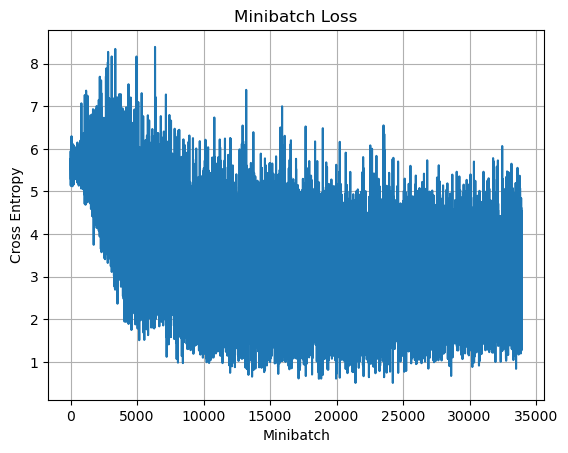

In [ ]:
utils.plot_minibatch_loss(minibatch_loss)

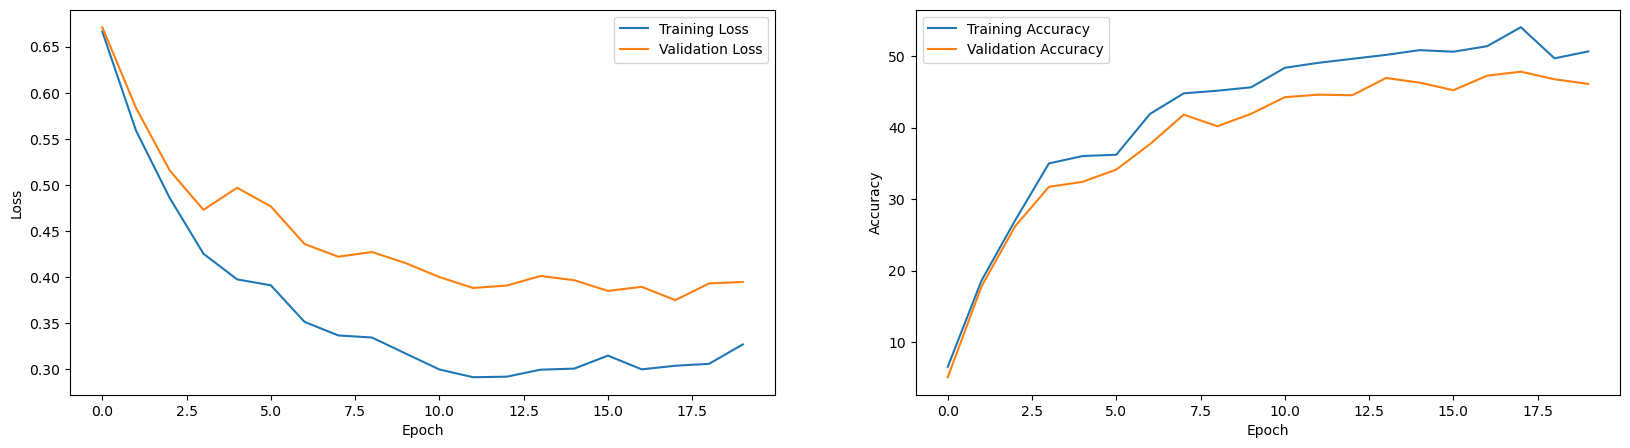

In [ ]:
utils.plot_train_and_valid_loss_and_accuracy(train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst)